Primeiramente iremos importar as bibliotecas e funções a serem utilizadas:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, make_scorer, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Leitura dos dados, renomeação de colunas e feature engineering:

In [4]:
df = pd.read_csv("C:\\Users\\gabri\\OneDrive\\Documentos\\predictive_maintenance.csv")
df = df.rename(columns=lambda x: x.split(' [')[0])
df['Diferença de Temperatura'] = df['Process temperature'] - df['Air temperature']
df.rename(columns={
    'Type': 'Qualidade',
    'Rotational speed': 'Velocidade de Rotação',
    'Torque': 'Torque',
    'Tool wear': 'Desgaste da Ferramenta',
    'Target': 'Falha'
}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   UDI                       10000 non-null  int64  
 1   Product ID                10000 non-null  object 
 2   Qualidade                 10000 non-null  object 
 3   Air temperature           10000 non-null  float64
 4   Process temperature       10000 non-null  float64
 5   Velocidade de Rotação     10000 non-null  int64  
 6   Torque                    10000 non-null  float64
 7   Desgaste da Ferramenta    10000 non-null  int64  
 8   Falha                     10000 non-null  int64  
 9   Failure Type              10000 non-null  object 
 10  Diferença de Temperatura  10000 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 859.5+ KB


As duas temperaturas foram transformadas na diferença entre elas pois isso traz mais informação sobre um processo mecânico, assim como, individualmente as duas features são altamente correlacionadas, dessa forma pode-se trazer mais informação ao modelo e simplifica-lo ao mesmo tempo.

Análise da proporção entre as classes:

In [5]:
df['Falha'].value_counts()


Falha
0    9661
1     339
Name: count, dtype: int64

Será utilizado a abordagem de Class Weight para resolver o problema de balanceamento de classes:

In [6]:
weight = 9661 / 339
class_weight = {0: 1, 1: weight}
class_weight

{0: 1, 1: 28.49852507374631}

Divisão dos dados em Features e Target:

In [7]:
# Divisão dos dados em Features e Target
x = df[['Qualidade', 'Diferença de Temperatura', 'Velocidade de Rotação', 'Torque', 'Desgaste da Ferramenta']]
y = df[['Falha']]



devido ao alto desbalanceamento das classes se torna necéssaria uma divisão estratificada entre os dados de treino validação e teste:

In [8]:
# Dividindo os dados em conjunto de treinamento (70%) e conjunto de teste (30%) de forma estratificada
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# Dividindo o conjunto de teste em conjunto de validação cruzada (50%) e conjunto de teste (50%) de forma estratificada
x_cv, x_test, y_cv, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Verificando os tamanhos dos conjuntos de dados
print(f"Tamanho do conjunto de treinamento: {x_train.shape[0]}, {y_train.shape[0]}")
print(f"Tamanho do conjunto de validação cruzada: {x_cv.shape[0]}, {y_cv.shape[0]}")
print(f"Tamanho do conjunto de teste: {x_test.shape[0]}, {y_test.shape[0]}")


Tamanho do conjunto de treinamento: 7000, 7000
Tamanho do conjunto de validação cruzada: 1500, 1500
Tamanho do conjunto de teste: 1500, 1500


Junção do x e y de treino para Análise exploratoria dos dados(EDA):

In [9]:
train_data = x_train.copy()
train_data['Falha'] = y_train
train_data

,Qualidade,Diferença de Temperatura,Velocidade de Rotação,Torque,Desgaste da Ferramenta,Falha
1888,M,9.6,1902,24.3,129,0
4858,L,8.6,1349,51.0,105,0
8990,L,10.7,1493,38.4,146,0
4901,M,8.7,1630,32.4,223,0
7957,H,11.0,2140,16.5,43,0
...,...,...,...,...,...,...
980,L,10.6,1409,42.8,134,0
4266,L,8.4,1440,39.5,146,0
7772,H,11.2,1464,41.0,29,0
5780,L,9.5,1517,42.4,113,0


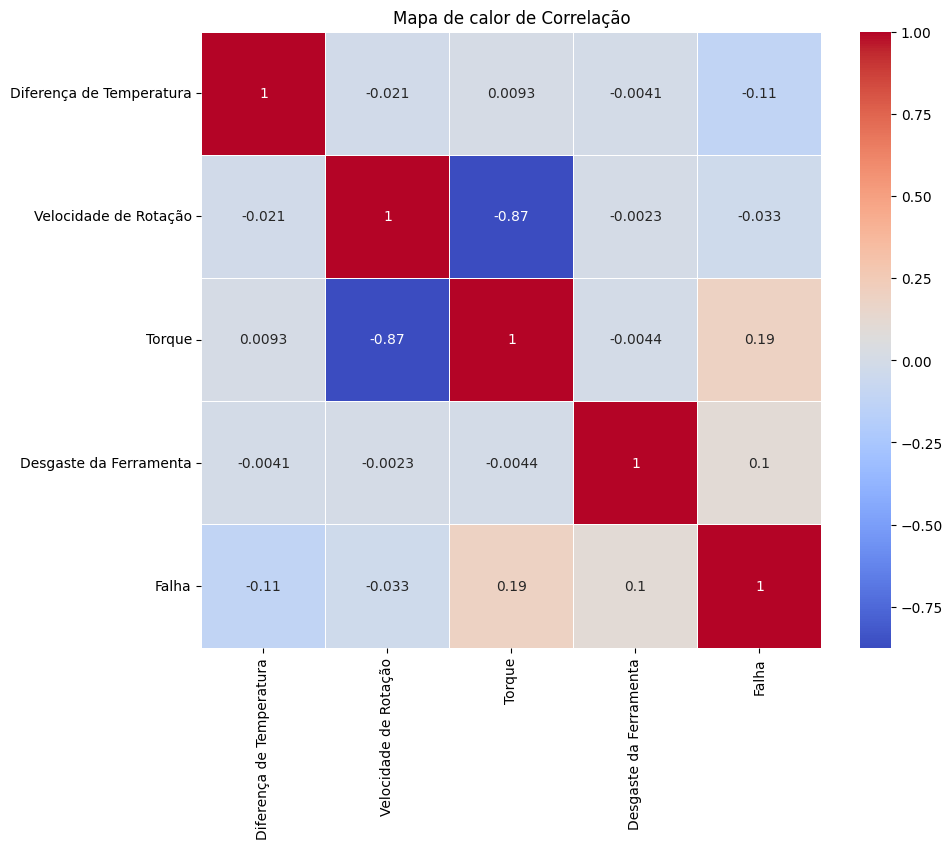

In [10]:
corr = train_data[['Diferença de Temperatura', 'Velocidade de Rotação', 'Torque', 'Desgaste da Ferramenta', 'Falha']].corr()

# Configurar o tamanho do gráfico
plt.figure(figsize=(10, 8))

# Gerar o heatmap de correlações
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

# Título do heatmap
plt.title('Mapa de calor de Correlação')

# Mostrar o gráfico
plt.show()

Percebe-se que o Torque e a Velocidade de rotação são altamente correlacionados, com um coeficiente -0,87, isso levanta o questionamento se todas as features realmente são necessárias ou se é possível remover alguma feature do modelo, simplificando o mesmo e mantendo a performance, porém, tanto o torque quanto a velocidade de rotação são importantes para identificação de falhas do ponto de vista técnico, então realizaremos diferentes testes.

In [11]:
# Calculo de variâncias
train_data[['Diferença de Temperatura', 'Velocidade de Rotação', 'Torque', 'Desgaste da Ferramenta']].var()

Diferença de Temperatura        0.998290
Velocidade de Rotação       32485.566994
Torque                        100.120340
Desgaste da Ferramenta       4078.598530
dtype: float64

Realizando uma análise das variâncias, percebe-se grandes diferenças em suas magnitudes, com a velocidade de rotação possuindo a maior entre elas, logo, será vantajoso realizar uma transformação de escalonamento posteriormente para normalizar os valores dessas variáveis.

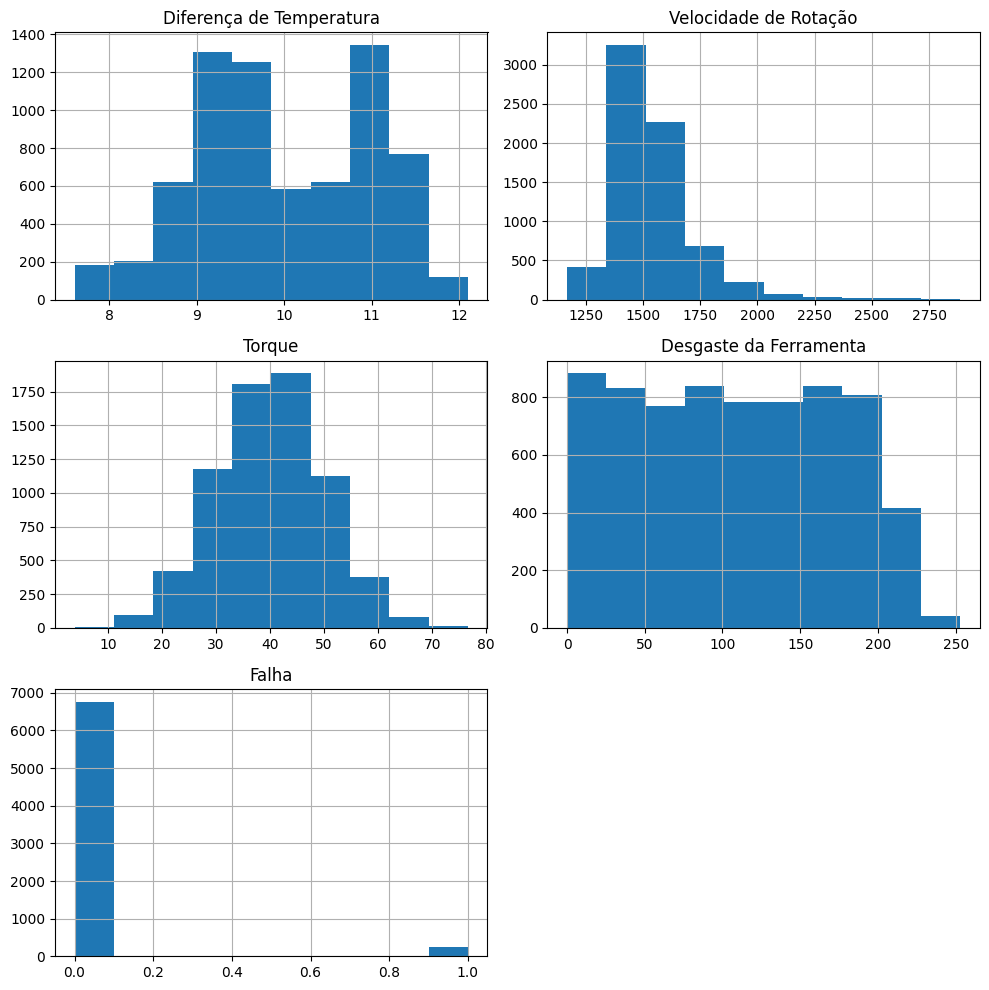

In [12]:
train_data.hist(figsize=(10, 10))  # figsize define o tamanho da figura
plt.tight_layout()  # Para evitar que os histogramas se sobreponham
plt.show()

Percebe-se que o Torque e a Velocidade de rotação possuem uma diferença significativa em suas distribuições, levando em conta que são altamente correlacionados, com o torque se aproximando mais do normal e a velocidade de rotação possuindo uma maior variância, como foi visto anteriormente.
O desgaste da ferramenta possui uma distribuição bem uniforme, tendo uma queda apenas em valores mais altos.

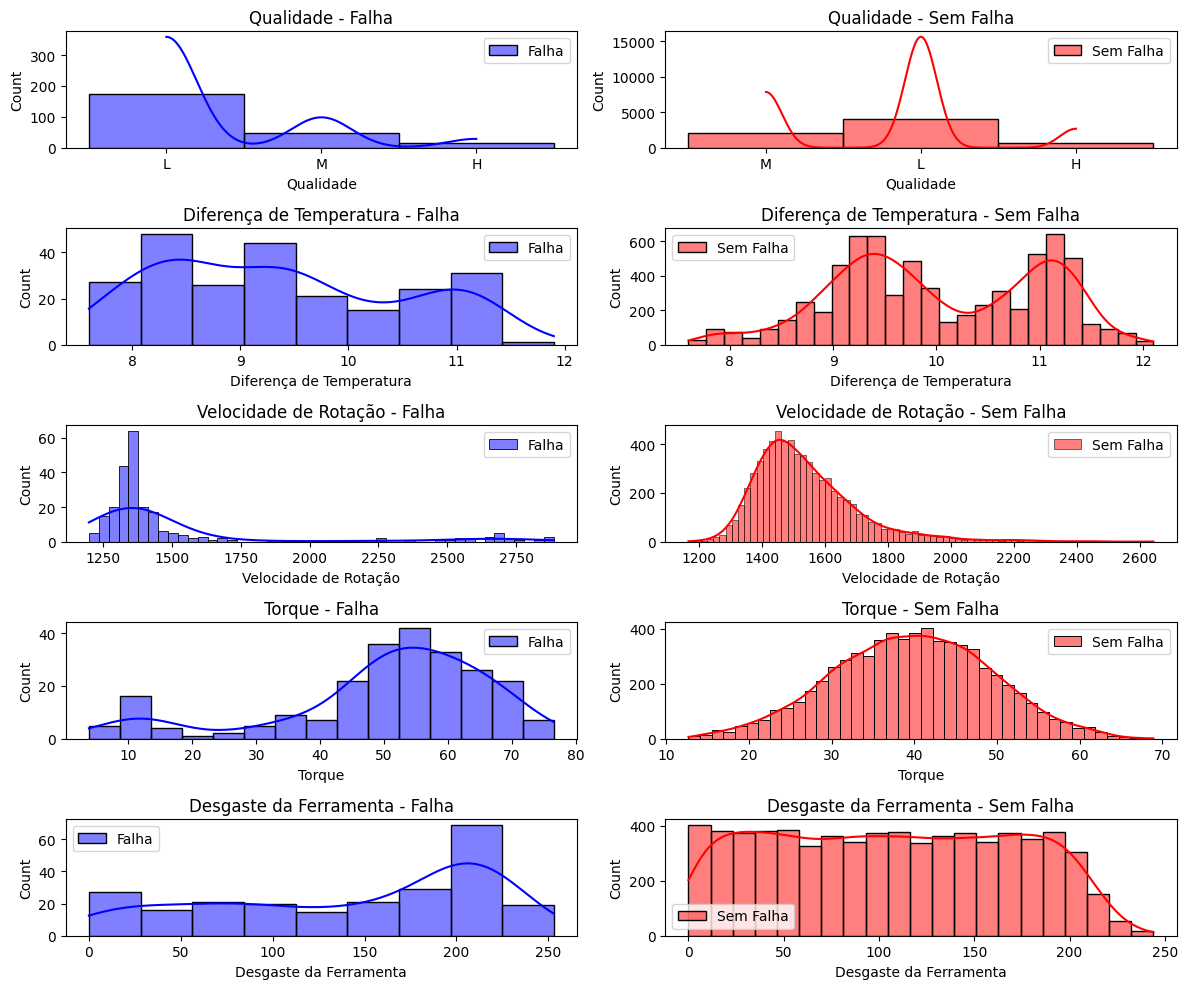

In [13]:
# Filtrando o DataFrame para os valores de target 1 e 0
train_data_1 = train_data[train_data['Falha'] == 1]
train_data_0 = train_data[train_data['Falha'] == 0]
train_data_1 = train_data_1.drop('Falha', axis = 1)
train_data_0 = train_data_0.drop('Falha', axis = 1)
# Definindo o número de colunas para plotagem
num_cols = len(train_data_1.columns)

# Criando subplots para cada coluna
fig, axs = plt.subplots(nrows=num_cols, ncols=2, figsize=(12, 2*num_cols))

# Plotando os histogramas para cada coluna
for i, col in enumerate(train_data_1.columns):
    sns.histplot(train_data_1[col], ax=axs[i, 0], kde=True, color='blue', label='Falha')
    sns.histplot(train_data_0[col], ax=axs[i, 1], kde=True, color='red', label='Sem Falha')
    axs[i, 0].legend()
    axs[i, 1].legend()
    axs[i, 0].set_title(f'{col} - Falha')
    axs[i, 1].set_title(f'{col} - Sem Falha')

plt.tight_layout()
plt.show()

• Pode-se claramente perceber que a maioria das falhas ocorrem na qualidade L, seguido do M e apenas uma minoria no H, porém não possui exatamente uma relação linear a ponto de usarmos um ordinal encoder.

• Pode-se observar para menores diferenças de temperatura ocorrem mais falhas do que em diferenças elevadas, mostrando que o feature engineering será eficaz para o modelo.

• Pode-se perceber que no geral quanto maior torque e menor rotação mais falhas. Porém, embora em um menor número, também ocorrem falhas para baixos torques e altas rotações. Isso indica que modelos que utilizam equações lineares como regressão logística e afins podem ter dificuldades em prever as falhas e modelos baseados em ensembles de árvores de decisões consigam um melhor resultado.

• Percebe-se claramente um maior número de falhas para um maior tempo de desgaste da ferramenta.

Agora será Realizada a transformação dos dados:

• Transformar a variavel categorica em valores 0 e 1 através do One Hot Enconding

• Escalar as variaveis numericas através do StandardScaler, para que todas se encontrem na mesma faixa de valores, facilitando o aprendizado dos algoritmos

In [14]:

columns_to_encode = ['Qualidade']
columns_to_scale = ['Diferença de Temperatura', 'Velocidade de Rotação', 'Torque', 'Desgaste da Ferramenta']
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), columns_to_encode),
     ('scaler', StandardScaler(),columns_to_scale)],
    remainder='passthrough'  # Leave other columns unchanged
)

# Função para transformar o conjunto de dados
def transform_data(ct, data):
    df_encoded = ct.transform(data)
    feature_names = ct.get_feature_names_out()
    return pd.DataFrame(df_encoded, columns=feature_names)

ct.fit(x_train)
# Aplicando a transformação ao x_train
x_traint = transform_data(ct, x_train)

# Aplicando a transformação ao x_cv e x_test
x_cvt = transform_data(ct, x_cv)
x_testt = transform_data(ct, x_test)


Baseado na EDA, serão utilizados 2 conjuntos de features, mantendo todas as features e removendo o torque devido a alta correlação para testar qual combinação de features trará um melhor resultado

In [15]:
#Baseado na EDA, serão utilizados 2 conjuntos de features, mantendo todas e removendo o torque devido a alta correlação para testar qual combinação de features trará um melhor resultado
x_traint2 = x_traint.drop('scaler__Torque', axis=1)
x_cvt2 = x_cvt.drop('scaler__Torque', axis=1)
random_state=42
x_traint2

,one_hot_encoder__Qualidade_H,one_hot_encoder__Qualidade_L,one_hot_encoder__Qualidade_M,scaler__Diferença de Temperatura,scaler__Velocidade de Rotação,scaler__Desgaste da Ferramenta
0,0.0,0.0,1.0,-0.392635,2.012835,0.334742
1,0.0,1.0,0.0,-1.393563,-1.055557,-0.041084
2,0.0,1.0,0.0,0.708385,-0.256554,0.600952
3,0.0,0.0,1.0,-1.293470,0.503608,1.806727
4,1.0,0.0,0.0,1.008663,3.333409,-1.011967
...,...,...,...,...,...,...
6995,0.0,1.0,0.0,0.608292,-0.722639,0.413039
6996,0.0,1.0,0.0,-1.593748,-0.550632,0.600952
6997,1.0,0.0,0.0,1.208849,-0.417465,-1.231199
6998,0.0,1.0,0.0,-0.492728,-0.123387,0.084192


Teste com modelos de Regressão Logistica:

In [16]:

logistic = LogisticRegression(class_weight='balanced')
logistic2 = LogisticRegression(class_weight='balanced')
logistic.fit(x_traint, y_train)
logistic2.fit(x_traint2, y_train)

yp_log = logistic.predict(x_traint)
yp_log2 = logistic2.predict(x_traint2)

ypcv_log = logistic.predict(x_cvt)
ypcv_log2 = logistic2.predict(x_cvt2)

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
def validação(y, ypred):
    # Calcular precisão
    precision = precision_score(y, ypred)

    # Calcular revocação
    recall = recall_score(y, ypred)

    # Calcular F1 score
    f1 = f1_score(y, ypred)

    accuracy = accuracy_score(y,ypred)

    roc = roc_auc_score(y,ypred)

    logloss = log_loss(y,ypred)

    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("ROC AUC:", roc)
    print("Acurácia:", accuracy)
    print("Log Loss:", logloss)

In [19]:
validação(y_train, yp_log)
validação(y_cv, ypcv_log)

Recall: 0.8227848101265823
Precision: 0.14285714285714285
F1 Score: 0.24344569288389514
ROC AUC: 0.824892331131604
Acurácia: 0.8268571428571428
Log Loss: 6.24070112965857
Recall: 0.7254901960784313
Precision: 0.137546468401487
F1 Score: 0.23125
ROC AUC: 0.7826898875492226
Acurácia: 0.836
Log Loss: 5.911159155815213


In [20]:
validação(y_train, yp_log2)
validação(y_cv, ypcv_log2)

Recall: 0.70042194092827
Precision: 0.06814449917898194
F1 Score: 0.12420501309390199
ROC AUC: 0.6823860406992377
Acurácia: 0.6655714285714286
Log Loss: 12.054027511989037
Recall: 0.7450980392156863
Precision: 0.0778688524590164
F1 Score: 0.14100185528756956
ROC AUC: 0.7172695165022531
Acurácia: 0.6913333333333334
Log Loss: 11.125474346107493


percebe-se a perfomance foi superior com todas as features, mas os resultados com regressão logistica foram bem abaixo do esperado, devido a uma baixa precisão. Em seguida, iremos realizar testes com modelos de RandomForest e XGBoost:

In [21]:
rf = RandomForestClassifier(class_weight= 'balanced', max_depth = 6)
rf2 = RandomForestClassifier(class_weight= 'balanced', max_depth = 5)


rf.fit(x_traint,y_train)
rf2.fit(x_traint2,y_train)


yp_rf = rf.predict(x_traint)
ypcv_rf = rf.predict(x_cvt)
yp_rf2 = rf2.predict(x_traint2)
ypcv_rf2 = rf2.predict(x_cvt2)

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [22]:
validação(y_train, yp_rf)
validação(y_cv, ypcv_rf)

Recall: 0.9535864978902954
Precision: 0.5317647058823529
F1 Score: 0.6827794561933535
ROC AUC: 0.9620808432080488
Acurácia: 0.97
Log Loss: 1.0813096016735146
Recall: 0.803921568627451
Precision: 0.4606741573033708
F1 Score: 0.5857142857142857
ROC AUC: 0.8853976373157959
Acurácia: 0.9613333333333334
Log Loss: 1.3936879310458634


In [23]:
validação(y_train, yp_rf2)
validação(y_cv, ypcv_rf2)

Recall: 0.890295358649789
Precision: 0.2743823146944083
F1 Score: 0.4194831013916501
ROC AUC: 0.9038937979113206
Acurácia: 0.9165714285714286
Log Loss: 3.0070705113206313
Recall: 0.8823529411764706
Precision: 0.2647058823529412
F1 Score: 0.4072398190045249
ROC AUC: 0.8980432752811269
Acurácia: 0.9126666666666666
Log Loss: 3.1478123959828976


In [24]:
xgb = XGBClassifier(scale_pos_weight=weight, objective='binary:logistic', max_depth=6 ,n_estimators= 100)
xgb2 = XGBClassifier(scale_pos_weight=weight, objective='binary:logistic', max_depth=5 ,n_estimators= 100)


xgb.fit(x_traint, y_train)
xgb2.fit(x_traint2, y_train)

yp_xgb = xgb.predict(x_traint)
ypcv_xgb = xgb.predict(x_cvt)
yp_xgb2 = xgb2.predict(x_traint2)
ypcv_xgb2 = xgb2.predict(x_cvt2)

In [25]:
validação(y_train, yp_xgb)
validação(y_cv, ypcv_xgb)

Recall: 1.0
Precision: 0.9957983193277311
F1 Score: 0.9978947368421053
ROC AUC: 0.9999260683128789
Acurácia: 0.9998571428571429
Log Loss: 0.0051490933413026714
Recall: 0.803921568627451
Precision: 0.803921568627451
F1 Score: 0.803921568627451
ROC AUC: 0.8985101286891569
Acurácia: 0.9866666666666667
Log Loss: 0.4805820451882289


In [26]:
validação(y_train, yp_xgb2)
validação(y_cv, ypcv_xgb2)

Recall: 1.0
Precision: 0.8006756756756757
F1 Score: 0.8893058161350844
ROC AUC: 0.9956380304598551
Acurácia: 0.9915714285714285
Log Loss: 0.30379650713684475
Recall: 0.6666666666666666
Precision: 0.5573770491803278
F1 Score: 0.6071428571428571
ROC AUC: 0.8240165631469979
Acurácia: 0.9706666666666667
Log Loss: 1.0572804994141032


Após comparação de resultados, pode-se perceber que mesmo tendo features altamente correlacionadas o conjunto 1 com todas as features obteve perfomance muito superior, pois mesmo tendo alta correlação cada feature impacta a falha de maneiras diferentes e não é completamente representada pela outra, isso traz uma importante reflexão de quem nem sempre devemos remover automaticamente features altamente correlacionadas. Além disso, o melhor modelo encontrado foi o XGBoost, após a seleção do modelo, será realizado o ajuste de hiperparâmetros através de uma busca em grade:

In [52]:
param_grid = {
'n_estimators': [50,75,100,120,150],
'max_depth': [5,6,7],
'learning_rate': [0.1, 0.01],
'subsample': [0.8, 0.9, 1],
'gamma': [0, 0.1, 0.2, 0.5],
'reg_alpha': [0, 0.001, 0.01],
'reg_lambda': [0, 0.001, 0.01],
'min_child_weight': [1, 2, 3],
'scale_pos_weight': [(9661 / 339)]
}
scoring = {
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
}
xgb_model = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring=scoring,refit='f1_score')
grid_search.fit(x_traint, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                         'learning_rate': [0.1, 0.01], 'max_depth': [5, 6, 7],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': [50, 75, 100, 120, 150],
                         'reg_alpha': [0, 0.001, 0.01],
                         'reg_lambda': [0, 0.001, 0.01],
                         'scale_pos_weight': [28.49852507374631],
                         'subsample': [0.8, 0.9, 1]},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score, response_method='predict'),
                      'recall_score': make_scorer(recall_score, response_method='predict')})

In [53]:
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados:
{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 120, 'reg_alpha': 0.001, 'reg_lambda': 0.01, 'scale_pos_weight': 28.49852507374631, 'subsample': 0.8}


In [54]:
print("Melhor pontuação de validação cruzada:", grid_search.best_score_)

Melhor pontuação de validação cruzada: 0.7746212121212123


In [70]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_cvt)
validação(y_cv,y_pred)  

Recall: 0.8235294117647058
Precision: 0.8076923076923077
F1 Score: 0.8155339805825242
ROC AUC: 0.9083140502577843
Acurácia: 0.9873333333333333
Log Loss: 0.4565529429288175


Percebe-se uma boa melhoria nos resultados após o ajuste de hiperparâmetros, para finalizar o projeto será realizada a predição para os dados de teste

In [71]:
y_predtest = best_model.predict(x_testt)
validação(y_test,y_predtest)  

Recall: 0.8431372549019608
Precision: 0.7962962962962963
F1 Score: 0.819047619047619
ROC AUC: 0.9177729062639549
Acurácia: 0.9873333333333333
Log Loss: 0.45655294292881743


Nas métricas finais do modelo obtivemos até uma melhora no recall e F1 Score, o que é bastante satisfatório